# Trying Retinal scan with NB

We are going to try to set a baseline for retinal scan with NB classification

In [42]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.utils.multiclass import unique_labels

import pandas as pd
import cv2
import seaborn as sn

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [54]:
from keras.models import Sequential,Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical
import tensorflow as tf
from keras.models import model_from_json
from keras import applications
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping





from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,RMSprop,SGD
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
#from pyimagesearch.smallervggnet import SmallerVGGNet

In [3]:
file_dir = os.path.dirname(os.path.abspath('__file__'))
print(file_dir)
sys.path.append(file_dir)

/home/pavan/W210


In [110]:
os.path.dirname("__file__")

''

In [4]:
# Load the csv data
orig_label = pd.read_csv("./Retinal-Images/trainLabels.csv")
orig_label.head(5)

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [10]:
orig_label.count()

image    35126
level    35126
dtype: int64

In [6]:
orig_label.groupby(['level']).count()

,image
level,
0,25810
1,2443
2,5292
3,873
4,708


In [7]:
from pyimagesearch.preprocessing import ImageToArrayPreprocessor
from pyimagesearch.preprocessing import AspectAwarePreprocessor

In [16]:
image_list = list()
IMAGE_SAMPLE = 10000
# We create a toy dataset of 'N' images, maintaining the split of the original 
images_percent = [50,15,20,8,7]
for level in range(5):
    # Get respective number of images in each level
    number_of_images = int(images_percent[level]*IMAGE_SAMPLE/100)
    sample_images = orig_label[orig_label.level==level].sample(n=number_of_images,axis=0)
    for i in range(len(sample_images)):
        image_name = sample_images.iloc[i].image
        #image_name = sample_images.iloc[i].image+'.jpeg'
        image_list.append(image_name)
len(image_list)

10000

In [17]:
random.shuffle(image_list)
# 80% is trained
n_train = int(IMAGE_SAMPLE*0.8)
n_test = IMAGE_SAMPLE-n_train
train_images = image_list[:n_train]
test_images = image_list[n_train:]

In [43]:
#from shutil import copyfile

#im_size = ['orig_','512_','256_']
#dir_list = ['/train/','/train_resize/','/train_resize_256/']
#for image in image_list:
#    counter=0
#    for fol in dir_list:
#        image_dir = os.getcwd()+'/Retinal-Images'+fol
#        image_loc = image_dir + image
#       copy_loc = os.getcwd()+'/Retinal-Images/sample_images/'+im_size[counter]+image
#        #print("Copying {} to {}".format(image_loc,copy_loc))
#       copyfile(image_loc,copy_loc)
#        counter+=1

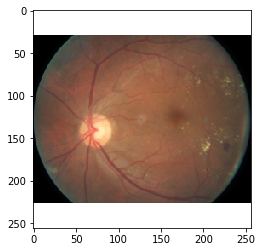

In [30]:
#dir_list = ['/train/','/train_resize/','/train_resize_256/']
#for image in image_list:
#    for fol in dir_list:
#        display_dir = os.getcwd()+'/Retinal-Images'+fol
#        image_loc = display_dir + image
#        plt.imshow(mpimg.imread(image_loc))

In [5]:
# Load the data
# 256x256 data to start with
#image_dir = os.getcwd()+'/Retinal-Images'+'/train_resize_128/'
#data = []
#labels = []
#for filename in os.listdir(image_dir):
#    imagePath = image_dir + filename
#    # load the image, pre-process it, and store it in the data list
#    image = cv2.imread(imagePath)
#    image = img_to_array(image)
#    data.append(image)
#    # Extract the image name without jpg
#    image_name = filename.split('.')[0]
#    # Get the class label from the image and update the
#    # labels list
#    label = orig_label[orig_label.image==image_name].level.values[0]
#    labels.append(label)

# Convert the values between 0-1
#data = np.array(data, dtype="float") / 255.0
#labels = np.array(labels)

In [57]:
# Load the data with image augmentation
# 256x256 data to start with
def create_data_labels(image_list,train=True):
    image_dir = os.getcwd()+'/Retinal-Images'+'/train_resize_224/'
    data = []
    labels = []
    aug_list = ["-flip","-flop","-rs"]
    for filename in image_list:
        if(train):
            for aug_n in range(4):
                if aug_n!=0:
                    aug = aug_list[aug_n-1]
                    imagePath = image_dir + filename + aug + ".jpeg"
                else:
                    imagePath = image_dir + filename + ".jpeg"
                #print(imagePath)
                # load the image, pre-process it, and store it in the data list
                if os.path.isfile(imagePath):
                    image = cv2.imread(imagePath)
                    image = img_to_array(image)
                    data.append(image)
                    # Get the class label from the image and update the
                    # labels list
                    label = orig_label[orig_label.image==filename].level.values[0]
                    # Change the label to binary
                    if label>0:
                        label=1
                    labels.append(label)
        else:
            # For test, we do not need augmentation
            imagePath = image_dir + filename + ".jpeg"
            #print(imagePath)
            # load the image, pre-process it, and store it in the data list
            if os.path.isfile(imagePath):
                image = cv2.imread(imagePath)
                image = img_to_array(image)
                data.append(image)
                # Get the class label from the image and update the
                # labels list
                label = orig_label[orig_label.image==filename].level.values[0]
                # Change the label to binary
                if label>0:
                    label=1
                labels.append(label)

    # Convert the values between 0-1
    #data = np.array(data, dtype="float") / 255.0
    data = np.array(data, dtype="int")
    labels = np.array(labels)
    return(data,labels)

In [58]:
trainX,trainY = create_data_labels(train_images,train=False)
testX,testY = create_data_labels(test_images,train=False)

In [59]:
print(trainX.shape)
print(testX.shape)

(8000, 224, 224, 3)
(2000, 224, 224, 3)


In [64]:
# Load the data
# 256x256 data to start with
#image_dir = os.getcwd()+'/Retinal-Images'+'/train_resize_128/'
#data = []
#labels = []
#for filename in image_list:
#    imagePath = image_dir + filename
#    # load the image, pre-process it, and store it in the data list
#    image = cv2.imread(imagePath)
#    image = img_to_array(image)
#    data.append(image)
#    # Extract the image name without jpg
#    image_name = filename.split('.')[0]
#    # Get the class label from the image and update the
#    # labels list
#    label = orig_label[orig_label.image==image_name].level.values[0]
#    # Change the label to binary
#    if label>0:
#        label=1
#    labels.append(label)

# Convert the values between 0-1
#data = np.array(data, dtype="float") / 255.0
#data = np.array(data, dtype="int")
#labels = np.array(labels)

In [60]:
length = trainX.shape[1]
width = trainX.shape[2]
depth = trainX.shape[3]
print(length,width,depth)
# number of classes is 5 if default. 2 if binary
num_classes = 2

224 224 3


In [125]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
#(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.2, random_state=42)

In [155]:
print(trainX.shape)
print(testX.shape)

(3200, 128, 128, 3)
(200, 128, 128, 3)


In [61]:
# Change to categorical
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

In [62]:
test_Y = np.argmax(testY,axis=1)


In [86]:
aug = ImageDataGenerator(horizontal_flip=True, zoom_range=0.2)

#aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
#                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
#                         horizontal_flip=True, fill_mode="nearest")

In [87]:
aug.fit(trainX)

In [25]:
def RMSE(actual, predict):
    diff = actual - predict
    diff = sum(diff**2) / len(actual)
    return np.sqrt(diff)

In [39]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



In [13]:
def save_model(model):
    # saving model
    json_model = model.model.to_json()
    open('model_architecture.json', 'w').write(json_model)
    # saving weights
    model.model.save_weights('model_weights.h5', overwrite=True)

def load_model(model_arch,model_weights):
    # loading model
    model = model_from_json(open(model_arch).read())
    model.load_weights(model_weights)
    #model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [55]:
def VGG_16_TL():
    model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (length, width, depth))
    for layer in model.layers[:5]:
        layer.trainable = False
    
    #Adding custom Layers 
    x = model.output
    x = Flatten()(x)
    x = Dense(4096, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation="relu")(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation="softmax")(x)
    adam_opt = Adam(lr=0.01)
    rms_opt = RMSprop(lr=0.01)
    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.5, nesterov=True)
    # creating the final model 
    model_final = Model(input = model.input, output = predictions)
    model_final.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])

    return model_final

def VGG_16():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),input_shape=(length,width,depth),activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    adam_opt = Adam(lr=0.01)
    rms_opt = RMSprop(lr=0.01)
    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.5, nesterov=True)
    model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
    #print(model.summary())
    return model

def CNN_FF():
    """ CNN with Feed Forward NN """
    model_conv = Sequential()
    model_conv.add(Conv2D(32, kernel_size=(5, 5), 
                                          input_shape=(length,width,depth),activation='relu'))
    model_conv.add(MaxPooling2D(pool_size=(2, 2)))
    model_conv.add(Conv2D(64, (5, 5), activation='relu'))
    model_conv.add(MaxPooling2D(pool_size=(2, 2)))
    model_conv.add(Flatten())
    model_conv.add(Dense(100))
    model_conv.add(Dropout(0.1))
    model_conv.add(Dense(num_classes, activation='softmax'))
    model_conv.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    #print(model_conv.summary())
    return model_conv

In [50]:
model_test = VGG_16()
model_test.summary()

/home/pavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  if __name__ == '__main__':
/home/pavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  del sys.path[0]
/home/pavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  from ipykernel import kernelapp as app
/home/pavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu")`
/home/pavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu")`
/home/pavan/anaconda3/lib/python3.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 65, 65, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 63, 128)       73856     
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 65, 65, 128)       0         
__________

In [ ]:
# Train the model
estimator_nn = KerasClassifier(build_fn=CNN_FF)
epochs = 5
batch_size = 10
for e in range(epochs):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in aug.flow(trainX, trainY, batch_size=batch_size):
        estimator_nn.fit(x_batch, y_batch)
        batches += 1
        if batches >= len(trainX) / 10:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break


Epoch 0
Epoch 1/1
10/10 [==============================] - 51s 5s/step - loss: 8.0151 - acc: 0.5000
Epoch 1/1
10/10 [==============================] - 50s 5s/step - loss: 9.7171 - acc: 0.3000
Epoch 1/1
10/10 [==============================] - 51s 5s/step - loss: 4.6154 - acc: 0.7000
Epoch 1/1
10/10 [==============================] - 51s 5s/step - loss: 7.4829 - acc: 0.4000
Epoch 1/1
10/10 [==============================] - 50s 5s/step - loss: 1.7271 - acc: 0.7000
Epoch 1/1
10/10 [==============================] - 51s 5s/step - loss: 4.8109 - acc: 0.7000
Epoch 1/1
10/10 [==============================] - 50s 5s/step - loss: 8.0151 - acc: 0.5000
Epoch 1/1
10/10 [==============================] - 52s 5s/step - loss: 9.6181 - acc: 0.4000
Epoch 1/1
10/10 [==============================] - 51s 5s/step - loss: 8.1934 - acc: 0.4000
Epoch 1/1
10/10 [==============================] - 50s 5s/step - loss: 10.4852 - acc: 0.3000
Epoch 1/1
10/10 [==============================] - 51s 5s/step - loss: 

In [89]:
prediction_nn_proba=estimator_nn.predict_proba(testX)
prediction_nn=estimator_nn.predict(testX)

In [189]:
#print(prediction_nn_proba)
#print(prediction_nn)

In [52]:
print(prediction_nn_proba)
print(prediction_nn)

[[0.49522266 0.50477743]
 [0.49310055 0.5068995 ]
 [0.48756853 0.51243144]
 [0.47512135 0.5248787 ]
 [0.49239755 0.5076024 ]
 [0.48389012 0.5161099 ]
 [0.48695415 0.51304585]
 [0.48912266 0.51087743]
 [0.48786306 0.512137  ]
 [0.4990397  0.5009603 ]
 [0.47950897 0.520491  ]
 [0.48169437 0.5183056 ]
 [0.49417984 0.5058202 ]
 [0.4894364  0.5105636 ]
 [0.45681903 0.543181  ]
 [0.48470926 0.5152907 ]
 [0.49075803 0.509242  ]
 [0.4882558  0.51174426]
 [0.48774058 0.5122594 ]
 [0.50458604 0.49541393]
 [0.49559766 0.5044024 ]
 [0.4736237  0.5263763 ]
 [0.4978224  0.5021776 ]
 [0.49462137 0.5053786 ]
 [0.47608972 0.52391034]
 [0.5018375  0.49816248]
 [0.45598134 0.5440186 ]
 [0.4837088  0.5162912 ]
 [0.5012964  0.49870363]
 [0.48585656 0.5141434 ]
 [0.48951983 0.5104802 ]
 [0.48888755 0.5111124 ]
 [0.4870149  0.51298505]
 [0.49782005 0.5021799 ]
 [0.493461   0.5065389 ]
 [0.48370194 0.51629806]
 [0.48829922 0.5117008 ]
 [0.50046676 0.49953318]
 [0.4823323  0.5176678 ]
 [0.49703392 0.50296605]


In [83]:
#rounded_prediction_s_cnn = np.around(prediction_nn)
predict_df = pd.DataFrame([test_Y,prediction_nn]).transpose()
predict_df.columns = ['Orig_Score','Pred_Score_CNN']
predict_df

,Orig_Score,Pred_Score_CNN
0,1,1
1,1,1
2,1,1
3,1,1
4,0,1
5,1,1
6,1,1
7,1,1
8,1,1
9,0,1


In [84]:
cohen_kappa_score(test_Y,prediction_nn,weights='quadratic')

0.07943731899048412

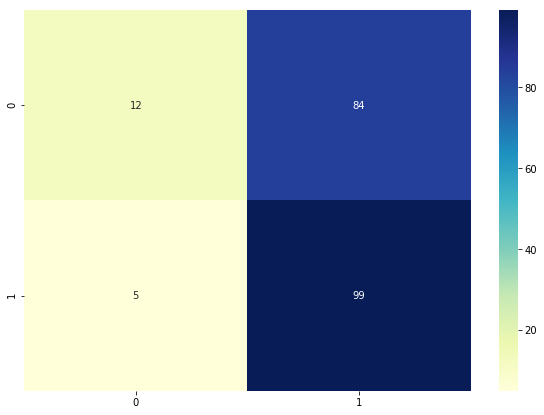

In [85]:
cnf = confusion_matrix(test_Y, prediction_nn)
df_cm = pd.DataFrame(cnf, index = [i for i in range(2)],
                  columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt='g')

## Transfer Learning

In [63]:
estimator_vgg_tl = KerasClassifier(build_fn=VGG_16_TL, epochs=1, batch_size=100)
estimator_vgg_tl.fit(trainX, trainY)

/home/pavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Epoch 1/1
 200/8000 [..............................] - ETA: 43:34 - loss: 6.1303 - acc: 0.4500

KeyboardInterrupt: 

### With Augmentation done in pre-processing

In [ ]:
# With Augmentation done during pre-process
estimator_vgg_aug_pp = KerasClassifier(build_fn=VGG_16, epochs=10, batch_size=100)
estimator_vgg_aug_pp.fit(trainX, trainY)

/home/pavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  """
/home/pavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  if __name__ == '__main__':
/home/pavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
/home/pavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu")`
  from ipykernel import kernelapp as app
/home/pavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activatio

Epoch 1/10
3200/3200 [==============================] - 804s 251ms/step - loss: 0.7082 - acc: 0.5125
Epoch 2/10
3200/3200 [==============================] - 664s 208ms/step - loss: 0.7049 - acc: 0.4978
Epoch 3/10
3200/3200 [==============================] - 668s 209ms/step - loss: 0.6939 - acc: 0.5253
Epoch 4/10
3200/3200 [==============================] - 662s 207ms/step - loss: 0.6996 - acc: 0.5019
Epoch 5/10
3200/3200 [==============================] - 670s 209ms/step - loss: 0.6953 - acc: 0.5134
Epoch 6/10
3200/3200 [==============================] - 669s 209ms/step - loss: 0.6957 - acc: 0.5075
Epoch 7/10
3200/3200 [==============================] - 669s 209ms/step - loss: 0.6929 - acc: 0.5222
Epoch 8/10
3200/3200 [==============================] - 669s 209ms/step - loss: 0.6955 - acc: 0.5253
Epoch 9/10
3200/3200 [==============================] - 669s 209ms/step - loss: 0.6951 - acc: 0.5153
Epoch 10/10
 900/3200 [=======>......................] - ETA: 7:56 - loss: 0.6950 - acc: 0.

In [183]:
# Predict for test data
prediction_vgg_aug_pp_proba=estimator_vgg_aug_pp.predict_proba(testX)
prediction_vgg_aug_pp=estimator_vgg_aug_pp.predict(testX)

In [184]:
print(prediction_vgg_aug_pp_proba)
print(prediction_vgg_aug_pp)

[[0.48175752 0.5182425 ]
 [0.49720705 0.5027929 ]
 [0.4934159  0.5065841 ]
 [0.4915357  0.5084643 ]
 [0.49588823 0.5041118 ]
 [0.48839226 0.51160777]
 [0.4836358  0.51636416]
 [0.49451765 0.50548244]
 [0.47464338 0.5253566 ]
 [0.50496495 0.49503502]
 [0.47477895 0.52522105]
 [0.50120836 0.49879166]
 [0.48160648 0.5183935 ]
 [0.5116437  0.48835635]
 [0.47314867 0.52685124]
 [0.4814467  0.51855326]
 [0.4846817  0.5153184 ]
 [0.48916587 0.5108341 ]
 [0.5042967  0.49570325]
 [0.48222113 0.5177788 ]
 [0.47286615 0.5271338 ]
 [0.53379184 0.46620822]
 [0.45923206 0.54076797]
 [0.48674378 0.51325625]
 [0.51095027 0.48904976]
 [0.48820382 0.5117962 ]
 [0.47559643 0.5244036 ]
 [0.47420913 0.52579087]
 [0.48502403 0.51497597]
 [0.5018131  0.49818692]
 [0.4930688  0.5069311 ]
 [0.4802314  0.5197686 ]
 [0.49383026 0.50616974]
 [0.49537784 0.5046221 ]
 [0.49392146 0.50607854]
 [0.50335854 0.49664143]
 [0.5022697  0.4977303 ]
 [0.5185492  0.48145083]
 [0.5056495  0.49435046]
 [0.45222375 0.5477762 ]


In [185]:
rmse_val_vgg = RMSE(test_Y,prediction_vgg_aug_pp)
# Find the overall RMSE value.
print("RMSE-VGG: ",rmse_val_vgg)
cohen_kappa_score(test_Y,prediction_vgg_aug_pp,weights='quadratic')


RMSE-VGG:  0.7


0.024584453070568335

In [186]:
#rounded_prediction_s_cnn = np.around(prediction_nn)
predict_df = pd.DataFrame([test_Y,prediction_vgg_aug_pp]).transpose()
predict_df.columns = ['Orig_Score','Pred_Score_VGG']
predict_df

,Orig_Score,Pred_Score_VGG
0,0,1
1,1,1
2,0,1
3,1,1
4,0,1
5,0,1
6,0,1
7,0,1
8,0,1
9,0,0


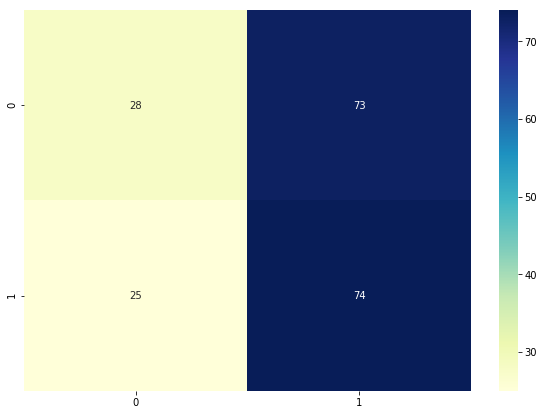

In [188]:
cnf = confusion_matrix(test_Y, prediction_vgg_aug_pp)
df_cm = pd.DataFrame(cnf, index = [i for i in range(2)],
                  columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt='g')

In [190]:
save_model(estimator_vgg_aug_pp)

### Load saved model from 10K images with augmentation and SGD

In [14]:
model_10k_vgg = load_model('model_architecture_vgg.json','model_weights_vgg.h5')

In [21]:
# Predict for test data
prediction_vgg_proba=model_10k_vgg.predict_proba(testX)
prediction_vgg=model_10k_vgg.predict(testX)

In [34]:
def selector(x):
    if x[0] > x[1]:
        return 0
    else:
        return 1
prediction_vgg = np.array([selector(xi) for xi in prediction_vgg_proba])
prediction_vgg.shape


(2000,)

In [36]:
rmse_val_vgg = RMSE(test_Y,prediction_vgg)
# Find the overall RMSE value.
print("RMSE-VGG: ",rmse_val_vgg)
cohen_kappa_score(test_Y,prediction_vgg,weights='quadratic')


RMSE-VGG:  0.6557438524302001


0.14189469651010578

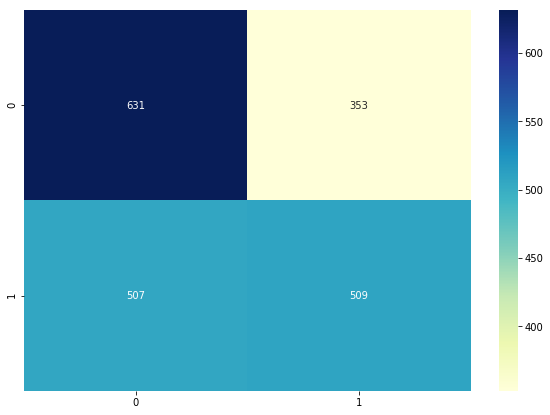

In [37]:
cnf = confusion_matrix(test_Y, prediction_vgg)
df_cm = pd.DataFrame(cnf, index = [i for i in range(2)],
                  columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt='g')

In [ ]:
# Train the model with augmentation
#estimator_vgg = KerasRegressor(build_fn=VGG_16, epochs=10, batch_size=10)
#estimator_vgg = KerasRegressor(build_fn=VGG_16)
estimator_vgg = KerasClassifier(build_fn=VGG_16)
epochs = 10
batch_size = 5
for e in range(epochs):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in aug.flow(trainX, trainY, batch_size=batch_size):
        estimator_vgg.fit(x_batch, y_batch)
        batches += 1
        if batches >= len(trainX) / 10:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break


Epoch 0


/home/pavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  import sys
/home/pavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
/home/pavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  del sys.path[0]
/home/pavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu")`
/home/pavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu")`
/home/pavan/anaconda3/lib/python3

Epoch 1/1
5/5 [==============================] - 5s 906ms/step - loss: 0.6930 - acc: 0.6000
Epoch 1/1
5/5 [==============================] - 5s 901ms/step - loss: 0.6933 - acc: 0.4000
Epoch 1/1
5/5 [==============================] - 4s 878ms/step - loss: 0.6937 - acc: 0.4000
Epoch 1/1
5/5 [==============================] - 5s 906ms/step - loss: 0.6932 - acc: 0.6000
Epoch 1/1
5/5 [==============================] - 4s 838ms/step - loss: 0.6933 - acc: 0.2000
Epoch 1/1
5/5 [==============================] - 4s 863ms/step - loss: 0.6931 - acc: 0.4000
Epoch 1/1
5/5 [==============================] - 5s 905ms/step - loss: 0.6931 - acc: 0.4000
Epoch 1/1
5/5 [==============================] - 5s 920ms/step - loss: 0.6929 - acc: 0.4000
Epoch 1/1
5/5 [==============================] - 5s 1s/step - loss: 0.6936 - acc: 0.4000
Epoch 1/1
5/5 [==============================] - 5s 998ms/step - loss: 0.6931 - acc: 0.4000
Epoch 1/1
5/5 [==============================] - 5s 1s/step - loss: 0.6932 - acc: 0

Epoch 1/1
5/5 [==============================] - 18s 4s/step - loss: 0.6937 - acc: 0.2000
Epoch 1/1
5/5 [==============================] - 19s 4s/step - loss: 0.6931 - acc: 0.4000
Epoch 1/1
5/5 [==============================] - 19s 4s/step - loss: 0.6929 - acc: 0.8000
Epoch 1/1
5/5 [==============================] - 20s 4s/step - loss: 0.6933 - acc: 0.2000
Epoch 1/1
5/5 [==============================] - 19s 4s/step - loss: 0.6943 - acc: 0.0000e+00
Epoch 1/1
5/5 [==============================] - 22s 4s/step - loss: 0.6934 - acc: 0.4000
Epoch 1/1
5/5 [==============================] - 20s 4s/step - loss: 0.6932 - acc: 0.4000
Epoch 1/1
5/5 [==============================] - 20s 4s/step - loss: 0.6932 - acc: 0.4000
Epoch 1/1
5/5 [==============================] - 20s 4s/step - loss: 0.6933 - acc: 0.4000
Epoch 1/1
5/5 [==============================] - 20s 4s/step - loss: 0.6929 - acc: 0.6000
Epoch 1/1
5/5 [==============================] - 20s 4s/step - loss: 0.6928 - acc: 0.6000
Epoch 

In [37]:
save_model(estimator_vgg)

In [43]:
# Predict for test data
prediction_vgg_proba=estimator_vgg.predict_proba(testX)
prediction_vgg=estimator_vgg.predict(testX)

In [40]:
prediction_vgg_proba

array([[0.4998646 , 0.5001354 ],
       [0.49973962, 0.5002604 ],
       [0.49985358, 0.50014645],
       [0.49980557, 0.5001944 ],
       [0.4996399 , 0.5003601 ],
       [0.4995709 , 0.5004291 ],
       [0.49981967, 0.50018036],
       [0.499738  , 0.50026196],
       [0.49985337, 0.5001466 ],
       [0.49987411, 0.50012594],
       [0.4996828 , 0.5003172 ],
       [0.4999153 , 0.50008464],
       [0.49961746, 0.5003825 ],
       [0.49967116, 0.5003289 ],
       [0.4995192 , 0.5004808 ],
       [0.49959937, 0.50040054],
       [0.49958512, 0.50041485],
       [0.49987465, 0.50012535],
       [0.49985293, 0.5001471 ],
       [0.49971995, 0.5002801 ],
       [0.4998075 , 0.5001925 ],
       [0.49983993, 0.50016004],
       [0.4997932 , 0.5002067 ],
       [0.49990585, 0.5000941 ],
       [0.4995529 , 0.50044715],
       [0.49944478, 0.5005552 ],
       [0.49956262, 0.5004373 ],
       [0.49957246, 0.5004275 ],
       [0.49959823, 0.50040174],
       [0.4997636 , 0.50023645],
       [0.

In [41]:
prediction_vgg

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [52]:
prediction_nn_proba

array([[1.00000000e+00, 2.73861733e-09, 5.99121735e-15, 2.87010034e-17,
        1.14438115e-09],
       [9.99999642e-01, 2.11116102e-07, 1.71461573e-13, 1.32729893e-14,
        9.17887775e-08],
       [1.00000000e+00, 1.37868472e-09, 2.06506675e-15, 1.21107944e-17,
        2.82106866e-10],
       [9.99808490e-01, 1.76273723e-04, 6.51842456e-08, 6.88036161e-09,
        1.51933900e-05],
       [1.00000000e+00, 1.03488371e-10, 1.71424679e-17, 5.15794643e-20,
        2.75119007e-11],
       [1.00000000e+00, 5.10855559e-11, 1.54198357e-18, 5.46417095e-21,
        4.76847763e-11],
       [1.00000000e+00, 2.12286242e-08, 1.38624565e-15, 1.08112116e-16,
        4.08702405e-09],
       [1.00000000e+00, 9.68660395e-12, 3.17664161e-19, 4.40000562e-22,
        2.47487664e-12],
       [1.00000000e+00, 2.04964917e-11, 8.61967991e-17, 1.61930315e-20,
        1.07613900e-11],
       [1.00000000e+00, 4.90433250e-10, 3.00991834e-16, 1.11816931e-18,
        4.21158164e-10],
       [1.00000000e+00, 5.8916

In [54]:
prediction_nn

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [44]:
#rmse_val_s_cnn = RMSE(testY,prediction_nn)
# Find the overall RMSE value.
#print("RMSE-simple CNN: ",rmse_val_s_cnn)
#print("RMSE-simple CNN with rounded predictions: ",RMSE(testY,np.around(prediction_nn)))
rmse_val_vgg = RMSE(test_Y,prediction_vgg)
# Find the overall RMSE value.
print("RMSE-VGG: ",rmse_val_vgg)

RMSE-VGG:  1.4832396974191326


In [45]:
#rounded_prediction_s_cnn = np.around(prediction_nn)
predict_df = pd.DataFrame([test_Y,prediction_vgg]).transpose()
predict_df.columns = ['Orig_Score','Pred_Score_VGG']
predict_df

,Orig_Score,Pred_Score_VGG
0,2,2
1,1,2
2,2,2
3,1,2
4,1,2
5,0,2
6,0,2
7,2,2
8,0,2
9,0,2


In [46]:
cohen_kappa_score(test_Y,prediction_vgg,weights='quadratic')

0.0

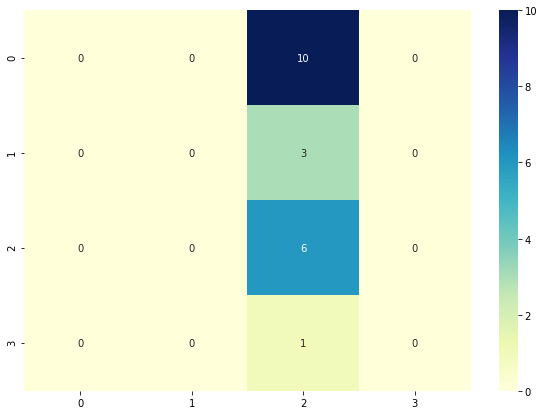

In [51]:
cnf = confusion_matrix(test_Y, prediction_vgg)
df_cm = pd.DataFrame(cnf, index = [i for i in range(4)],
                  columns = [i for i in range(4)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt='g')